# Setup

In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import datetime
import cv2
from keras import backend as K
from keras.layers import Layer,InputSpec
from keras import layers
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate, Dense, Conv2D, MaxPooling2D, Flatten, Input, Activation, add, AveragePooling2D, BatchNormalization, Dropout
%matplotlib inline
import shutil
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Data Preparation

In [3]:
# Environment variable
main_dir = 'D:/Data/HAM100000 - Harvard Dataset'
main_img_dir = main_dir + '/img_data'
preprocessed_data_dir = main_dir + '/preprocessed_data'
train_dir = preprocessed_data_dir + '/train'
test_dir = preprocessed_data_dir + '/val'
train_label = preprocessed_data_dir + '/train_label.csv'
val_label = preprocessed_data_dir + '/val_label.csv'

model_path = 'resnet152SoftAtt_10split_LRStr.hdf5'

In [4]:
target_size = (224, 224)
def Get_data(df_path, img_path, _target_size):
    img_list = []
    labels = []
    ages = []
    sex_list = []
    localizations = []
    
    df = pd.read_csv(df_path)
    for index, row in df.iterrows():
        img_list.append(cv2.imread(img_path + '/' + row['image_id'] + '.jpg'))
        labels.append(row['dx'])
        ages.append(float(row['age']))
        sex_list.append(row['sex'])
        localizations.append(row['localization'])
    for x in range(len(img_list)):
        img_list[x] = tf.keras.preprocessing.image.smart_resize(img_list[x], _target_size)
        img_list[x] = tf.keras.applications.resnet.preprocess_input(img_list[x])
    le = preprocessing.LabelEncoder()
    le.fit(labels)
    labels = le.transform(labels)
    labels = tf.keras.utils.to_categorical(labels)
    return (img_list, ages, sex_list, localizations), labels

In [5]:
train_df = pd.read_csv(train_label)
train_df.head()

,Unnamed: 0,image_id,dx,age,sex,localization
0,0,ISIC_0027419,bkl,80.0,male,scalp
1,1,ISIC_0025030,bkl,80.0,male,scalp
2,2,ISIC_0026769,bkl,80.0,male,scalp
3,3,ISIC_0025661,bkl,80.0,male,scalp
4,4,ISIC_0031633,bkl,75.0,male,ear


In [6]:
val_df = pd.read_csv(val_label)
val_df.head()

,Unnamed: 0,image_id,dx,age,sex,localization
0,2973,ISIC_0031531,bcc,70.0,male,back
1,483,ISIC_0026526,bkl,60.0,male,face
2,8870,ISIC_0026805,nv,75.0,female,lower extremity
3,1991,ISIC_0030756,mel,85.0,male,chest
4,8324,ISIC_0024834,nv,70.0,male,chest


## Training Data

In [7]:
(train_img_lst, train_ages, train_sexes, train_localizations), labels = Get_data(train_label, main_img_dir, target_size)

In [8]:
any(elem is None for elem in train_img_lst)

False

In [9]:
print("Number of images: {}".format(len(train_img_lst)))
print("Image shape: {0} {1}".format(train_img_lst[0].shape[0], train_img_lst[0].shape[1]))
print("Example of Age: {}".format(train_ages[0]))
print("Example of Sex: {}".format(train_sexes[0]))
print("Example of Localization: {}".format(train_localizations[0]))

Number of images: 8962
Image shape: 224 224
Example of Age: 80.0
Example of Sex: male
Example of Localization: scalp


## Validation Data

In [10]:
(val_img_lst, val_ages, val_sexes, val_localizations), val_labels = Get_data(val_label, main_img_dir, target_size)

In [11]:
any(elem is None for elem in val_img_lst)

False

In [12]:
print("Number of images: {}".format(len(val_img_lst)))
print("Image shape: {0} {1}".format(val_img_lst[0].shape[0], val_img_lst[0].shape[1]))
print("Example of Age: {}".format(val_ages[0]))
print("Example of Sex: {}".format(val_sexes[0]))
print("Example of Localization: {}".format(val_localizations[0]))

Number of images: 996
Image shape: 224 224
Example of Age: 70.0
Example of Sex: male
Example of Localization: back


# Model

## Input Block

In [13]:
age_input = tf.keras.Input(shape=(1,), name='age', dtype=tf.float32)
sex_input = tf.keras.Input(shape=(1,), name='sex', dtype=tf.string)
localizations_input = tf.keras.Input(shape=(1,), name='localization', dtype=tf.string)

inputs = {'age' : age_input,
         'sex' : sex_input,
         'local' : localizations_input}

In [14]:
norm = layers.Normalization()
norm.adapt(np.array(train_df[['age']]))
age_norm_input = norm(age_input)
age_norm_input

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization')>

In [15]:
# Sex input
sex_lookup = layers.StringLookup(vocabulary=np.unique(train_df['sex']))
sex_one_hot = layers.CategoryEncoding(num_tokens=sex_lookup.vocabulary_size())

preprocessed_sex_input = sex_lookup(sex_input)
preprocessed_sex_input = sex_one_hot(preprocessed_sex_input)
preprocessed_sex_input

<KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding')>

In [16]:
# Localization input
local_lookup = layers.StringLookup(vocabulary=np.unique(train_df['localization']))
local_one_hot = layers.CategoryEncoding(num_tokens=local_lookup.vocabulary_size())

preprocess_local_input = local_lookup(localizations_input)
preprocess_local_input = local_one_hot(preprocess_local_input)
preprocess_local_input

<KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'category_encoding_1')>

In [17]:
preprocessed_inputs = [age_norm_input, preprocessed_sex_input, preprocess_local_input]
preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)

# preprocessed_Model = tf.keras.Model(inputs, preprocessed_inputs_cat)
# tf.keras.utils.plot_model(model = preprocessed_Model , rankdir="LR", dpi=72, show_shapes=True)

preprocessed_inputs_cat

<KerasTensor: shape=(None, 21) dtype=float32 (created by layer 'concatenate')>

## Soft Attention

In [18]:
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
import tensorflow as tf

In [19]:
class SoftAttention(Layer):
    def __init__(self,ch,m,concat_with_x=False,aggregate=False,**kwargs):
        self.channels=int(ch)
        self.multiheads = m
        self.aggregate_channels = aggregate
        self.concat_input_with_scaled = concat_with_x

        
        super(SoftAttention,self).__init__(**kwargs)

    def build(self,input_shape):

        self.i_shape = input_shape

        kernel_shape_conv3d = (self.channels, 3, 3) + (1, self.multiheads) # DHWC
    
        self.out_attention_maps_shape = input_shape[0:1]+(self.multiheads,)+input_shape[1:-1]
        
        if self.aggregate_channels==False:

            self.out_features_shape = input_shape[:-1]+(input_shape[-1]+(input_shape[-1]*self.multiheads),)
        else:
            if self.concat_input_with_scaled:
                self.out_features_shape = input_shape[:-1]+(input_shape[-1]*2,)
            else:
                self.out_features_shape = input_shape
        

        self.kernel_conv3d = self.add_weight(shape=kernel_shape_conv3d,
                                        initializer='he_uniform',
                                        name='kernel_conv3d')
        self.bias_conv3d = self.add_weight(shape=(self.multiheads,),
                                      initializer='zeros',
                                      name='bias_conv3d')

        super(SoftAttention, self).build(input_shape)

    def call(self, x):

        exp_x = K.expand_dims(x,axis=-1)

        c3d = K.conv3d(exp_x,
                     kernel=self.kernel_conv3d,
                     strides=(1,1,self.i_shape[-1]), padding='same', data_format='channels_last')
        conv3d = K.bias_add(c3d,
                        self.bias_conv3d)
        conv3d = kl.Activation('relu')(conv3d)

        conv3d = K.permute_dimensions(conv3d,pattern=(0,4,1,2,3))

        
        conv3d = K.squeeze(conv3d, axis=-1)
        conv3d = K.reshape(conv3d,shape=(-1, self.multiheads ,self.i_shape[1]*self.i_shape[2]))

        softmax_alpha = K.softmax(conv3d, axis=-1) 
        softmax_alpha = kl.Reshape(target_shape=(self.multiheads, self.i_shape[1],self.i_shape[2]))(softmax_alpha)

        
        if self.aggregate_channels==False:
            exp_softmax_alpha = K.expand_dims(softmax_alpha, axis=-1)       
            exp_softmax_alpha = K.permute_dimensions(exp_softmax_alpha,pattern=(0,2,3,1,4))
   
            x_exp = K.expand_dims(x,axis=-2)
   
            u = kl.Multiply()([exp_softmax_alpha, x_exp])   
  
            u = kl.Reshape(target_shape=(self.i_shape[1],self.i_shape[2],u.shape[-1]*u.shape[-2]))(u)

        else:
            exp_softmax_alpha = K.permute_dimensions(softmax_alpha,pattern=(0,2,3,1))

            exp_softmax_alpha = K.sum(exp_softmax_alpha,axis=-1)

            exp_softmax_alpha = K.expand_dims(exp_softmax_alpha, axis=-1)

            u = kl.Multiply()([exp_softmax_alpha, x])   

        if self.concat_input_with_scaled:
            o = kl.Concatenate(axis=-1)([u,x])
        else:
            o = u
        
        return [o, softmax_alpha]

    def compute_output_shape(self, input_shape): 
        return [self.out_features_shape, self.out_attention_maps_shape]

    
    def get_config(self):
        return super(SoftAttention,self).get_config()

## Base Model

In [20]:
ResNet152 = tf.keras.applications.ResNet152(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,

)

inputs['image'] = ResNet152.input

# Exclude the last 28 layers of the model.
ResNet152_output = ResNet152.layers[-23].output

## Final Model

In [21]:
attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(ResNet152_output.shape[-1]),name='soft_attention')(ResNet152_output)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
ResNet152_output=(MaxPooling2D(pool_size=(2, 2),padding="same")(ResNet152_output))

ResNet152_output = layers.Concatenate()([ResNet152_output, attention_layer])
ResNet152_output = Activation('relu')(ResNet152_output)
ResNet152_output = Dropout(0.5)(ResNet152_output)

In [22]:
output = Flatten()(ResNet152_output)
preprocessed_inputs_cat = (layers.Dense(4096, activation = 'relu')(preprocessed_inputs_cat))
output = layers.Concatenate()([output, preprocessed_inputs_cat])
output = Dense(7, activation='softmax')(output)
model = Model(inputs=inputs, outputs=output)

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block6_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block6_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block6_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block6_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block6_2_relu[0][0]']    
                                                                                                  
 conv3_block6_3_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block6_3_conv[0][0]']    
 ization) 

 n)                                                                                               
                                                                                                  
 conv4_block1_0_conv (Conv2D)   (None, 14, 14, 1024  525312      ['conv3_block8_out[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block1_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block1_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block1_0_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block1_0_conv[0][0]']    
 ization)                       )                                                                 
          

                                                                                                  
 conv4_block4_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block4_1_relu[0][0]']    
                                                                                                  
 conv4_block4_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block4_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block4_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block4_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block4_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block4_2_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv4_block7_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block7_1_relu[0][0]']    
                                                                                                  
 conv4_block7_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block7_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block7_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block10_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block10_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block10_2_conv (Conv2D)  (None, 14, 14, 256)  590080      ['conv4_block10_1_relu[0][0]']   
                                                                                                  
 conv4_block10_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block10_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block10_2_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block10_2_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block13_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block13_2_conv (Conv2D)  (None, 14, 14, 256)  590080      ['conv4_block13_1_relu[0][0]']   
                                                                                                  
 conv4_block13_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block13_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block13_2_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block13_2_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv4_block16_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block16_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_2_conv (Conv2D)  (None, 14, 14, 256)  590080      ['conv4_block16_1_relu[0][0]']   
                                                                                                  
 conv4_block16_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block16_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

 conv4_block19_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block19_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block19_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block19_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block19_2_conv (Conv2D)  (None, 14, 14, 256)  590080      ['conv4_block19_1_relu[0][0]']   
                                                                                                  
 conv4_block19_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block19_2_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block22_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block22_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block22_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block22_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block22_2_conv (Conv2D)  (None, 14, 14, 256)  590080      ['conv4_block22_1_relu[0][0]']   
                                                                                                  
 conv4_block22_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block22_2_conv[0][0]']   
 lization)

 conv4_block25_1_conv (Conv2D)  (None, 14, 14, 256)  262400      ['conv4_block24_out[0][0]']      
                                                                                                  
 conv4_block25_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block25_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block25_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block25_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block25_2_conv (Conv2D)  (None, 14, 14, 256)  590080      ['conv4_block25_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block28_1_conv (Conv2D)  (None, 14, 14, 256)  262400      ['conv4_block27_out[0][0]']      
                                                                                                  
 conv4_block28_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block28_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block28_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block28_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block28_2_conv (Conv2D)  (None, 14, 14, 256)  590080      ['conv4_block28_1_relu[0][0]']   
          

                                )                                                                 
                                                                                                  
 conv4_block31_1_conv (Conv2D)  (None, 14, 14, 256)  262400      ['conv4_block30_out[0][0]']      
                                                                                                  
 conv4_block31_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block31_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block31_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block31_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_blo

 conv4_block33_out (Activation)  (None, 14, 14, 1024  0          ['conv4_block33_add[0][0]']      
                                )                                                                 
                                                                                                  
 conv4_block34_1_conv (Conv2D)  (None, 14, 14, 256)  262400      ['conv4_block33_out[0][0]']      
                                                                                                  
 conv4_block34_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block34_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block34_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block34_1_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block36_out (Activation)  (None, 14, 14, 1024  0          ['conv4_block36_add[0][0]']      
                                )                                                                 
                                                                                                  
 conv5_block1_1_conv (Conv2D)   (None, 7, 7, 512)    524800      ['conv4_block36_out[0][0]']      
                                                                                                  
 conv5_block1_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block1_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block1_1_bn[0][0]']      
 n)       

## Training

In [24]:
feature_dict = {'age' : np.array(train_ages),
                'sex' : np.array(train_sexes),
                'local' : np.array(train_localizations),
                'image' : np.array(train_img_lst)}

In [25]:
val_dict = {'age' : np.array(val_ages),
                'sex' : np.array(val_sexes),
                'local' : np.array(val_localizations),
                'image' : np.array(val_img_lst)}

In [26]:
class_weights = { 
                    0: 4.37,  # akiec
                    1: 2.78,  # bcc
                    2: 1.3,  # bkl
                    3: 12.44,  # df
                    4: 1.28,  # mel
                    5: 0.21,  # nv
                    6: 10,  # vasc
                }


checkpoint =  ModelCheckpoint(filepath = model_path,monitor='val_accuracy',save_best_only=True,save_weights_only=True)

In [27]:
opt1=tf.keras.optimizers.Adam(learning_rate=0.001,epsilon=0.1)
model.compile(optimizer=opt1,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [28]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              verbose = 1, mode = 'min',
                              patience=5, min_lr=0.0000001)

In [29]:
batch_size = 32 

Earlystop = EarlyStopping(monitor='val_loss', mode='min',patience=35, min_delta=0.001)

with tf.device('/GPU:0'):
    history = model.fit(feature_dict, labels,
                        steps_per_epoch=(len(train_df)/10),
                        epochs=500,
                        validation_data=(val_dict, val_labels), 
                        validation_steps=len(val_df)/batch_size,
                        callbacks=[checkpoint, Earlystop, reduce_lr],
                        class_weight=class_weights)

Epoch 1/500
896/896 [==============================] - 980s 935ms/step - loss: 9.0592 - accuracy: 0.2603 - val_loss: 3.8844 - val_accuracy: 0.1004 - lr: 0.0010
Epoch 2/500
896/896 [==============================] - 937s 1s/step - loss: 3.5535 - accuracy: 0.2515 - val_loss: 14.3340 - val_accuracy: 0.2259 - lr: 0.0010
Epoch 3/500
896/896 [==============================] - 859s 958ms/step - loss: 3.4780 - accuracy: 0.3250 - val_loss: 2.9741 - val_accuracy: 0.4237 - lr: 0.0010
Epoch 4/500
896/896 [==============================] - 861s 960ms/step - loss: 3.3489 - accuracy: 0.3676 - val_loss: 24.2638 - val_accuracy: 0.2841 - lr: 0.0010
Epoch 5/500
896/896 [==============================] - 851s 950ms/step - loss: 3.0000 - accuracy: 0.4046 - val_loss: 1.9356 - val_accuracy: 0.3886 - lr: 0.0010
Epoch 6/500
896/896 [==============================] - 870s 971ms/step - loss: 2.3887 - accuracy: 0.4623 - val_loss: 1.3867 - val_accuracy: 0.5321 - lr: 0.0010
Epoch 7/500
896/896 [====================

Epoch 46/500
896/896 [==============================] - 861s 960ms/step - loss: 1.4337 - accuracy: 0.6077 - val_loss: 1.0141 - val_accuracy: 0.6185 - lr: 1.0000e-07
Epoch 47/500
896/896 [==============================] - 866s 966ms/step - loss: 1.1374 - accuracy: 0.6096 - val_loss: 1.0661 - val_accuracy: 0.6215 - lr: 1.0000e-07
Epoch 48/500
896/896 [==============================] - 901s 1s/step - loss: 1.1384 - accuracy: 0.6070 - val_loss: 1.0905 - val_accuracy: 0.6195 - lr: 1.0000e-07
Epoch 49/500
896/896 [==============================] - 892s 995ms/step - loss: 1.3027 - accuracy: 0.6083 - val_loss: 0.9998 - val_accuracy: 0.6195 - lr: 1.0000e-07
Epoch 50/500
896/896 [==============================] - 877s 979ms/step - loss: 1.1052 - accuracy: 0.6046 - val_loss: 1.1038 - val_accuracy: 0.6245 - lr: 1.0000e-07
Epoch 51/500
896/896 [==============================] - 874s 975ms/step - loss: 1.4585 - accuracy: 0.6143 - val_loss: 1.0293 - val_accuracy: 0.6195 - lr: 1.0000e-07
Epoch 52/500


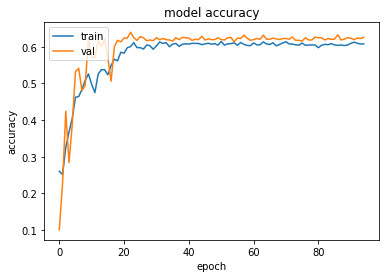

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

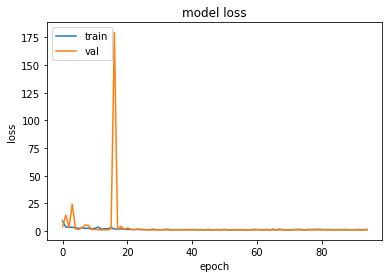

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [32]:
from tensorflow.keras import models
model.load_weights(model_path)

In [33]:
batch_size = 32 
predictions = model.predict(val_dict, steps=len(val_df)/batch_size, verbose=0)

# Classification report

In [34]:
#geting predictions on test dataset
y_pred = np.argmax(predictions, axis=1)
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
#getting the true labels per image 
y_true = np.argmax(val_labels, axis=1)
#getting the predicted labels per image 
y_prob=predictions
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

# Creating classification report 
report = classification_report(y_true, y_pred, target_names=targetnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

       akiec       0.31      0.45      0.37        33
         bcc       0.51      0.55      0.53        51
         bkl       0.52      0.59      0.55       109
          df       0.14      0.92      0.24        12
         mel       0.34      0.56      0.42       111
          nv       0.95      0.67      0.79       666
        vasc       0.26      0.71      0.38        14

    accuracy                           0.64       996
   macro avg       0.43      0.64      0.47       996
weighted avg       0.77      0.64      0.68       996



# Confusion Matrix Metrics

In [35]:
from sklearn.metrics import multilabel_confusion_matrix
multi_cm = multilabel_confusion_matrix(y_true, y_pred)
#print(multi_cm)

# TN     FP
# FN     TP

In [36]:
def cm_compute(_cm, _index, _name):
    print("Confusion Matrix of {}".format(_name))
    print(_cm[index])
    TP = _cm[index][1][1]
    FP = _cm[index][0][1]
    FN = _cm[index][1][0]
    TN = _cm[index][0][0]
    print("True Positive of {0}: {1}".format(_name, TP))
    print("False Positive of {0}: {1}".format(_name, FP))
    print("False Negative of {0}: {1}".format(_name, FN))
    print("True Negative of {0}: {1}".format(_name, TN))
    sensitivity = TP/(TP + FN)
    specificity = TN/(TN + FP)
    print("Sensitivity of {0}: {1}".format(_name, sensitivity))
    print("Specificity of {0}: {1}".format(_name, specificity))
    print("Precision of {0}: {1}".format(_name, TP/(TP + FP)))
    print("Accuracy of {0}: {1}".format(_name, (TP+TN)/(TP + FP + FN + TN)))
    print("Balanced Accuracy of {0} : {1}".format(_name, (sensitivity + specificity)/2))
    print("F1 Score of {0}: {1}".format(_name, (2*TP)/(2*TP + FP + FN)))

### akiec       

In [37]:
index = 0
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of akiec
[[929  34]
 [ 18  15]]
True Positive of akiec: 15
False Positive of akiec: 34
False Negative of akiec: 18
True Negative of akiec: 929
Sensitivity of akiec: 0.45454545454545453
Specificity of akiec: 0.9646936656282451
Precision of akiec: 0.30612244897959184
Accuracy of akiec: 0.9477911646586346
Balanced Accuracy of akiec : 0.7096195600868498
F1 Score of akiec: 0.36585365853658536


### bcc       

In [38]:
index = 1
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of bcc
[[918  27]
 [ 23  28]]
True Positive of bcc: 28
False Positive of bcc: 27
False Negative of bcc: 23
True Negative of bcc: 918
Sensitivity of bcc: 0.5490196078431373
Specificity of bcc: 0.9714285714285714
Precision of bcc: 0.509090909090909
Accuracy of bcc: 0.9497991967871486
Balanced Accuracy of bcc : 0.7602240896358543
F1 Score of bcc: 0.5283018867924528


### bkl

In [39]:
index = 2
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of bkl
[[829  58]
 [ 45  64]]
True Positive of bkl: 64
False Positive of bkl: 58
False Negative of bkl: 45
True Negative of bkl: 829
Sensitivity of bkl: 0.5871559633027523
Specificity of bkl: 0.9346110484780158
Precision of bkl: 0.5245901639344263
Accuracy of bkl: 0.8965863453815262
Balanced Accuracy of bkl : 0.760883505890384
F1 Score of bkl: 0.5541125541125541


### df 

In [40]:
index = 3
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of df
[[916  68]
 [  1  11]]
True Positive of df: 11
False Positive of df: 68
False Negative of df: 1
True Negative of df: 916
Sensitivity of df: 0.9166666666666666
Specificity of df: 0.9308943089430894
Precision of df: 0.13924050632911392
Accuracy of df: 0.9307228915662651
Balanced Accuracy of df : 0.9237804878048781
F1 Score of df: 0.24175824175824176


### mel

In [41]:
index = 4
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of mel
[[765 120]
 [ 49  62]]
True Positive of mel: 62
False Positive of mel: 120
False Negative of mel: 49
True Negative of mel: 765
Sensitivity of mel: 0.5585585585585585
Specificity of mel: 0.864406779661017
Precision of mel: 0.34065934065934067
Accuracy of mel: 0.8303212851405622
Balanced Accuracy of mel : 0.7114826691097877
F1 Score of mel: 0.4232081911262799


### nv

In [42]:
index = 5
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of nv
[[307  23]
 [219 447]]
True Positive of nv: 447
False Positive of nv: 23
False Negative of nv: 219
True Negative of nv: 307
Sensitivity of nv: 0.6711711711711712
Specificity of nv: 0.9303030303030303
Precision of nv: 0.951063829787234
Accuracy of nv: 0.7570281124497992
Balanced Accuracy of nv : 0.8007371007371007
F1 Score of nv: 0.7869718309859155


### vasc

In [43]:
index = 6
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of vasc
[[953  29]
 [  4  10]]
True Positive of vasc: 10
False Positive of vasc: 29
False Negative of vasc: 4
True Negative of vasc: 953
Sensitivity of vasc: 0.7142857142857143
Specificity of vasc: 0.9704684317718941
Precision of vasc: 0.2564102564102564
Accuracy of vasc: 0.9668674698795181
Balanced Accuracy of vasc : 0.8423770730288043
F1 Score of vasc: 0.37735849056603776


## Weighted, Macro, Micro, ROC AUC

In [44]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("weighted Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='weighted')))

Precision: 0.7728196106084267
Recall: 0.6395582329317269
Accuracy: 0.6395582329317269
weighted Roc score: 0.9017808429156047


In [45]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='macro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='macro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("Macro Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='macro')))

Precision: 0.43245392217012457
Recall: 0.6359147337676364
Accuracy: 0.6395582329317269
Macro Roc score: 0.9208167884726345


In [46]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='micro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='micro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
tpr={}
fpr={}
roc_auc={}
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro Roc score: " + str(roc_auc["micro"]))

Precision: 0.6395582329317269
Recall: 0.6395582329317269
Accuracy: 0.6395582329317269
Micro Roc score: 0.9215764497078003


In [47]:
fpr = {}
tpr = {}
roc_auc = {}
for i in range(7):
    r = roc_auc_score(y_test[:, i], y_prob[:, i])
    print("The ROC AUC score of "+targetnames[i]+" is: "+str(r))

The ROC AUC score of akiec is: 0.9542779823153654
The ROC AUC score of bcc is: 0.9304699657640834
The ROC AUC score of bkl is: 0.8726922002834003
The ROC AUC score of df is: 0.9811144986449865
The ROC AUC score of mel is: 0.8356288491881713
The ROC AUC score of nv is: 0.9100850850850851
The ROC AUC score of vasc is: 0.9614489380273494


In [48]:
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])

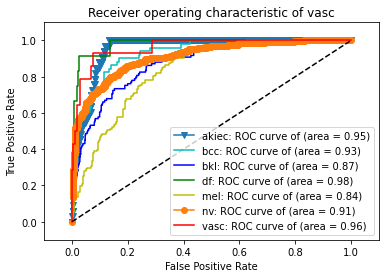

In [49]:
plt.plot(fpr[0], tpr[0],'v-',label='akiec: ROC curve of (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1],'c',label='bcc: ROC curve of (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2],'b',label='bkl: ROC curve of (area = %0.2f)' % roc_auc[2])
plt.plot(fpr[3], tpr[3],'g',label='df: ROC curve of (area = %0.2f)' % roc_auc[3])
plt.plot(fpr[4], tpr[4],'y',label='mel: ROC curve of (area = %0.2f)' % roc_auc[4])
plt.plot(fpr[5], tpr[5],'o-',label='nv: ROC curve of (area = %0.2f)' % roc_auc[5])
plt.plot(fpr[6], tpr[6],'r',label='vasc: ROC curve of (area = %0.2f)' % roc_auc[6])

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of %s'%targetnames[i])
plt.legend(loc="lower right")
plt.show()